In [1]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install tensorflow_data_validation

In [2]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sqlalchemy as sq
import sklearn as sk
import scipy as sp
import seaborn as sns
from dotenv import load_dotenv
from IPython.display import clear_output
from matplotlib import pyplot as plt
from DataService import DataService

2022-11-29 04:01:28.483037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 04:01:28.599694: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('/tf')
PGUSER = os.getenv('POSTGRES_USER')
PGPW = os.getenv('POSTGRES_PW')
PGDB = os.getenv('POSTGRES_DB')
NULLFLAG = -9999

In [4]:
# Connect to the database
pullService = DataService(PGDB, PGUSER, PGPW)
db_pull_con = pullService.connect()

pushService = DataService(PGDB, PGUSER, PGPW)
db_push_con = pushService.connect()

In [5]:
# Load the data
fireWeather = "FireWeather"
query = "SELECT * FROM public.\"{}\";".format(fireWeather)
dfEval = pd.read_sql(query, db_pull_con)

In [6]:
print(dfEval.count())
print(dfEval.describe())

EntryID                 428
FIRE_ID                 428
FIRENAME                428
YEAR                    428
MONTH                   428
DAY                     428
REP_DATE                428
SIZE_HA                 428
size_ha_bin             428
ClimateID               428
OneYear                 428
OneMonth                428
OneMeanTemp             428
OneMinTemp              428
OneMaxTemp              428
OneMeanDewPoint         428
OneMinDewPoint          428
OneMaxDewPoint          428
OneMeanHumidity         428
OneMinHumidity          428
OneMaxHumidity          428
OneMeanPressure         426
OneMinPressure          426
OneMaxPressure          426
OneMeanWindSpeed        426
OneMinWindSpeed         426
OneMaxWindSpeed         426
OneMeanWindChill        426
OneMinWindChill         426
OneMaxWindChill         426
OneTotalPrecip          428
OneMeanWindDirection    426
TwoYear                 428
TwoMonth                428
TwoMeanTemp             428
TwoMinTemp          

In [7]:
# Drop the columns that are not needed for the model
dfEval.drop(columns=['OneMonth', 'OneYear', 'TwoMonth', 'TwoYear'])
print(dfEval.count())
print(dfEval.head())

EntryID                 428
FIRE_ID                 428
FIRENAME                428
YEAR                    428
MONTH                   428
DAY                     428
REP_DATE                428
SIZE_HA                 428
size_ha_bin             428
ClimateID               428
OneYear                 428
OneMonth                428
OneMeanTemp             428
OneMinTemp              428
OneMaxTemp              428
OneMeanDewPoint         428
OneMinDewPoint          428
OneMaxDewPoint          428
OneMeanHumidity         428
OneMinHumidity          428
OneMaxHumidity          428
OneMeanPressure         426
OneMinPressure          426
OneMaxPressure          426
OneMeanWindSpeed        426
OneMinWindSpeed         426
OneMaxWindSpeed         426
OneMeanWindChill        426
OneMinWindChill         426
OneMaxWindChill         426
OneTotalPrecip          428
OneMeanWindDirection    426
TwoYear                 428
TwoMonth                428
TwoMeanTemp             428
TwoMinTemp          

In [8]:
# split data into train validate test 6 2 2
# dfTrain = dfEval.sample(frac=0.6, random_state=0)
# dfTest = dfEval.drop(dfTrain.index)
# dfTest = dfTest.sample(frac=0.5, random_state=0)
# dfValidate = dfEval.drop(dfTrain.index)
# dfValidate = dfValidate.drop(dfTest.index)

In [9]:
# randomly select 6 years from 2010-2019 for training
dfTrain = dfEval[dfEval['YEAR'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016])]
dfValidate = dfEval[dfEval['YEAR'].isin([2017, 2018])]
dfTest = dfEval[dfEval['YEAR'].isin([2019, 2020])]

In [10]:
# Store our random selection, run once
# randomTrain = "RandomTrain"
# dfTrain.to_sql(randomTrain, db_push_con, if_exists='replace', index=False)

# randomTest = "RandomTest"
# dfTest.to_sql(randomTest, db_push_con, if_exists='replace', index=False)

# randomValidate = "RandomValidate"
# dfValidate.to_sql(randomValidate, db_push_con, if_exists='replace', index=False)

In [11]:
trainStats = tfdv.generate_statistics_from_dataframe(dfTrain)

In [12]:
tfdv.visualize_statistics(trainStats)


In [13]:
schema = tfdv.infer_schema(statistics=trainStats)
tfdv.display_schema(schema=schema)


,Type,Presence,Valency,Domain
Feature name,,,,
'EntryID',INT,required,,-
'FIRE_ID',BYTES,required,,-
'FIRENAME',BYTES,required,,-
'YEAR',INT,required,,-
'MONTH',INT,required,,-
'DAY',INT,required,,-
'REP_DATE',BYTES,required,,-
'SIZE_HA',FLOAT,required,,-
'size_ha_bin',INT,required,,-


,Values
Domain,
'ClimateID',"'2202200', '2202202', '3062696', '3062697', '3072655', '4060983', '4061620', '4061629', '4063605', '4064155', '4067655', '406QLD0', '5061649'"


In [14]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


In [15]:
Y_train = dfTrain['SIZE_HA'].copy(deep=True)
Y_train.fillna(Y_train.mean(), inplace=True)

Y_train_discrete = dfTrain['size_ha_bin'].copy(deep=True)
Y_train_discrete.fillna(Y_train_discrete.min(), inplace=True)

X_train = dfTrain.drop(columns=['MONTH', 'SIZE_HA', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])
X_train.fillna(X_train.mean(), inplace=True)
X_train_one = X_train.drop(columns=['TwoMeanTemp', 'TwoMinTemp', 'TwoMaxTemp', 'TwoMeanDewPoint', 'TwoMinDewPoint', 'TwoMaxDewPoint',
                                     'TwoMeanHumidity', 'TwoMinHumidity', 'TwoMaxHumidity', 'TwoMeanPressure', 'TwoMinPressure',
                                     'TwoMaxPressure', 'TwoMeanWindSpeed', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMeanWindChill',
                                     'TwoMinWindChill', 'TwoMaxWindChill', 'TwoTotalPrecip', 'TwoMeanWindDirection'])
X_train_two = X_train.drop(columns=['OneMeanTemp', 'OneMinTemp', 'OneMaxTemp', 'OneMeanDewPoint', 'OneMinDewPoint', 'OneMaxDewPoint',
                                     'OneMeanHumidity', 'OneMinHumidity', 'OneMaxHumidity', 'OneMeanPressure', 'OneMinPressure',
                                     'OneMaxPressure', 'OneMeanWindSpeed', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMeanWindChill',
                                      'OneMinWindChill', 'OneMaxWindChill', 'OneTotalPrecip', 'OneMeanWindDirection'])

X_train_means_one = X_train_one.drop(columns=['OneMinTemp', 'OneMaxTemp', 'OneMinDewPoint', 'OneMaxDewPoint', 'OneMinHumidity', 'OneMaxHumidity',
                                              'OneMinPressure', 'OneMaxPressure', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMinWindChill',
                                              'OneMaxWindChill'])

X_train_means_two = X_train_two.drop(columns=['TwoMinTemp', 'TwoMaxTemp', 'TwoMinDewPoint', 'TwoMaxDewPoint', 'TwoMinHumidity', 'TwoMaxHumidity',
                                                'TwoMinPressure', 'TwoMaxPressure', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMinWindChill',
                                                'TwoMaxWindChill'])

dfTrainScaled = dfTrain.copy(deep=True)
dfTrainScaled.fillna(dfTrainScaled.mean(), inplace=True)
dfTrainScaled = dfTrainScaled.drop(columns=['MONTH', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])

/tmp/ipykernel_3074/365260978.py:27: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfTrainScaled.fillna(dfTrainScaled.mean(), inplace=True)


In [16]:
# regularize y values using z score
dfTrainScaled = (dfTrainScaled - dfTrainScaled.mean()) / dfTrainScaled.std()
# set max value to 3 zscore
dfTrainScaled[dfTrainScaled > 3] = 3
# set min value to -3 zscore
dfTrainScaled[dfTrainScaled < -3] = -3

# shift the wole train set to be positive
dfTrainScaled = dfTrainScaled + 3

In [17]:
# regularize y using log scale
Y_train = np.log(Y_train)
# regularize y values using z score
Y_train = (Y_train - Y_train.mean()) / Y_train.std()
# set max value to 3 zscore
Y_train[Y_train > 3] = 3

In [18]:
X_train.count()

OneMeanTemp             336
OneMinTemp              336
OneMaxTemp              336
OneMeanDewPoint         336
OneMinDewPoint          336
OneMaxDewPoint          336
OneMeanHumidity         336
OneMinHumidity          336
OneMaxHumidity          336
OneMeanPressure         336
OneMinPressure          336
OneMaxPressure          336
OneMeanWindSpeed        336
OneMinWindSpeed         336
OneMaxWindSpeed         336
OneMeanWindChill        336
OneMinWindChill         336
OneMaxWindChill         336
OneTotalPrecip          336
OneMeanWindDirection    336
TwoMeanTemp             336
TwoMinTemp              336
TwoMaxTemp              336
TwoMeanDewPoint         336
TwoMinDewPoint          336
TwoMaxDewPoint          336
TwoMeanHumidity         336
TwoMinHumidity          336
TwoMaxHumidity          336
TwoMeanPressure         336
TwoMinPressure          336
TwoMaxPressure          336
TwoMeanWindSpeed        336
TwoMinWindSpeed         336
TwoMaxWindSpeed         336
TwoMeanWindChill    

train_dataset = X_train_means_one.copy(deep=True)
train_dataset['SIZE_HA'] = Y_train
pairplotOne = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

train_dataset = X_train_means_two.copy(deep=True)
train_dataset['SIZE_HA'] = Y_train
pairplotTwo = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [19]:
dfall = X_train_means_one.copy(deep=True)
dfall['SIZE_HA'] = Y_train

In [20]:
print(Y_train.describe())
print(Y_train.isnull().sum().sum())
print(X_train_means_one.count())
print(X_train_means_one.isna().sum().sum())
print(X_train_means_one.dtypes)

count   336.0
mean     -0.0
std       1.0
min      -1.6
25%      -0.8
50%      -0.1
75%       0.6
max       3.0
Name: SIZE_HA, dtype: float64
0
OneMeanTemp             336
OneMeanDewPoint         336
OneMeanHumidity         336
OneMeanPressure         336
OneMeanWindSpeed        336
OneMeanWindChill        336
OneTotalPrecip          336
OneMeanWindDirection    336
dtype: int64
0
OneMeanTemp             float64
OneMeanDewPoint         float64
OneMeanHumidity         float64
OneMeanPressure         float64
OneMeanWindSpeed        float64
OneMeanWindChill        float64
OneTotalPrecip          float64
OneMeanWindDirection    float64
dtype: object


In [21]:
X_train_select_means_one = X_train_means_one[['OneMeanTemp', 'OneMeanHumidity' ]].copy(deep=True)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


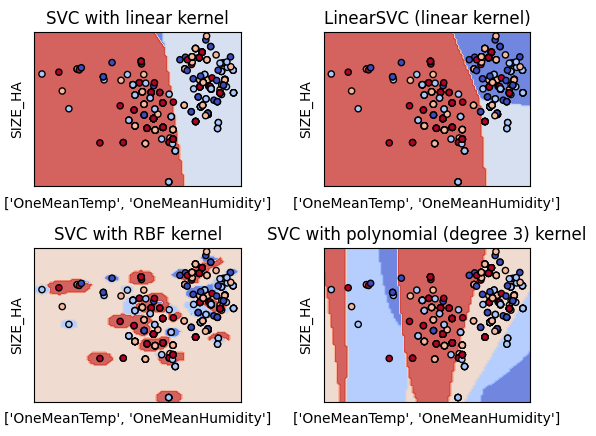

In [22]:
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=1000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X_train_select_means_one, Y_train_discrete) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train_select_means_one['OneMeanTemp'].to_numpy(), X_train_select_means_one['OneMeanHumidity'].to_numpy()

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_train_select_means_one,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=['OneMeanTemp', 'OneMeanHumidity'],
        ylabel="SIZE_HA",
    )
    ax.scatter(X0, X1, c=Y_train_discrete, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()